In [28]:
import pickle
import pandas as pd
import numpy as np
from datetime import date
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf

In [29]:
# Importamos las predicciones para el backtesting y datos necesarios
file = open("Datos/prediccionesCAPM.pkl", "rb")
predicciones = pickle.load(file)

lista_tickers = np.load("Datos/tickers_yahoo.npy", allow_pickle = True)
lista_tickers = list(map(lambda x: x.replace('BRK-B', 'BRK.B'), lista_tickers))
lista_tickers = list(map(lambda x: x.replace('BF-B', 'BF.B'), lista_tickers))

file_SP500 = open("Datos/precioSP500.pkl", "rb")
SP500 = pickle.load(file_SP500)
file_SP500.close()

datos_precios = pd.read_csv("Datos/tabla_precios.csv")
datos_precios = datos_precios.rename(columns={'BF-B': 'BF.B', 'BRK-B': 'BRK.B'})
datos_precios.set_index('Date', inplace=True)
datos_precios.index = pd.to_datetime(datos_precios.index).date

# Robot CAPM

In [30]:
class Robot_CAPM():
    def __init__(self, capital, lim_inf = -0.01, lim_sup = 0.01):
        self.capital_inicial = capital
        self.capital = capital
        self.lim_inf = lim_inf
        self.lim_sup = lim_sup
        #self.margen_venta = 1
        self.margin_call_lim = 1 + 0.538461538461539 #Segun la FED cuanto tiene que subir el precio en un short listing para que tengas que añadir dinero a tu margen
        
    @staticmethod
    def comparativa_SP(year):
        prices_sp500 = SP500[SP500.index < pd.to_datetime(f"{year}-12-31")]
        prices_sp500 = prices_sp500[prices_sp500.index > pd.to_datetime(f"{year}-1-1")]
        rent = ((prices_sp500[-1] / prices_sp500[0]) - 1) * 100
        print(f"La rentabilidad total del SP500 para el año {year} fue de {round(rent,4)}%\n")
        return
        
    @staticmethod
    def rentabilidad(capital_final, capital_inicial):
        return capital_final / capital_inicial - 1
    
    def margin_call(self, ticker):
        '''Simplemente cerramos la posicion al recibir el margin call'''
        self.stop_venta(ticker)
        return
    
    def compra(self, ticker):
        '''Compramos todas las acciones con el capital disponible'''
        self.acciones[ticker] = self.invertir[ticker] / self.price_ticker
        self.capital -=  self.invertir[ticker]
        self.posiciones[ticker] = "compra"
        return

    def stop_compra(self, ticker):
        self.invertir[ticker] = self.price_ticker * self.acciones[ticker]
        self.capital += self.price_ticker * self.acciones[ticker]
        self.acciones[ticker] = 0
        self.posiciones[ticker] = "none"
        return

    def venta(self, ticker):
        self.acciones[ticker] = - self.invertir[ticker] / self.price_ticker
        self.capital -= self.invertir[ticker]
        self.posiciones[ticker] = "venta"
        self.precio_venta[ticker] = self.price_ticker
        return

    def stop_venta(self, ticker):
        self.capital -= (2 * (self.precio_venta[ticker] * self.acciones[ticker]) - self.price_ticker * self.acciones[ticker])
        self.invertir[ticker] += self.precio_venta[ticker] * - self.acciones[ticker] - self.price_ticker * - self.acciones[ticker]
        self.acciones[ticker] = 0
        self.posiciones[ticker] = "none"
        return
        
    ############
    
    
    def simular(self, lista_tickers, dataframe_precios, start_date, end_date):
        self.invertir = {}
        self.lista_tickers = lista_tickers
        self.posiciones = dict(zip(self.lista_tickers, ["none"] * len(self.lista_tickers)))
        self.acciones = dict(zip(self.lista_tickers, [0] * len(self.lista_tickers)))
        self.precio_venta = dict(zip(self.lista_tickers, [0] * len(self.lista_tickers)))
        self.rentabilidades = dict(zip(self.lista_tickers, np.zeros(len(self.lista_tickers))))
        ##
        self.totales = {item: {} for item in self.lista_tickers}
        
        # Simular CAPM (bucle por fechas con bucle por ticker dentro)
        for fecha in pd.date_range(start_date, end_date).date:
            for ticker in lista_tickers:
                try:
                    # Intenta acceder al valor en el diccionario
                    prediccion = predicciones[ticker][fecha]
                except KeyError:
                    # Si hay un KeyError, siguiente iteracion
                    continue
                    
                self.price_ticker = dataframe_precios[ticker].loc[fecha]
                
                if math.isnan(self.price_ticker):
                    continue
                self.invertir[ticker] = self.invertir.get(ticker, self.capital_inicial / 500)
                    
                # Logica de invertir en funcion de limtes establecidos
                if prediccion > self.lim_sup and self.posiciones[ticker] == "none":
                    self.compra(ticker)
                if prediccion < self.lim_inf and self.posiciones[ticker] == "none":
                    self.venta(ticker)
                
                if prediccion < 0 and self.posiciones[ticker] == "compra":
                    self.stop_compra(ticker)
                if prediccion > 0 and self.posiciones[ticker] == "venta":
                    self.stop_venta(ticker)
                
                if fecha == pd.to_datetime(end_date).date() or fecha == pd.to_datetime("31-10-2022").date(): #or fecha == pd.to_datetime("29-12-2017").date():
                    if self.posiciones[ticker] == "compra":
                        self.stop_compra(ticker)
                    if self.posiciones[ticker] == "venta":
                        self.stop_venta(ticker)
                    self.rentabilidades[ticker] = self.invertir[ticker] / (self.capital_inicial / 500) - 1
                
                self.totales[ticker][fecha] = [self.capital, np.abs(self.acciones[ticker] * self.price_ticker)]
        return   

## Limites 1%

/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/543690461.py:5: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")
/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/289205683.py:95: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if fecha == pd.to_datetime(end_date).date() or fecha == pd.to_datetime("31-10-2022").date(): #or fecha == pd.to_datetime("29-12-2017").date():


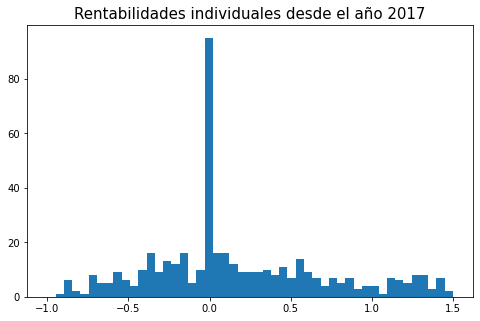

count    505.000000
mean       0.416199
std        1.048022
min       -3.129069
25%       -0.106970
50%        0.080255
75%        0.749124
max       12.181072
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 41.8361%



In [31]:
capital = 10000000
year = 2017

robot = Robot_CAPM(capital = capital, lim_inf = -0.01, lim_sup = 0.01)
robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")

plt.figure(figsize = (8, 5))

plt.hist(robot.rentabilidades.values(), bins = np.linspace(-1, 1.5, 50))
plt.title(f"Rentabilidades individuales desde el año {year}", fontsize = 15)
plt.show()
print(pd.Series(robot.rentabilidades.values()).describe())
r_total = round(robot.rentabilidad(robot.capital, robot.capital_inicial) * 100, 4)
print(f"La rentabilidad total del robot desde el año {year} fue de {r_total}%\n")

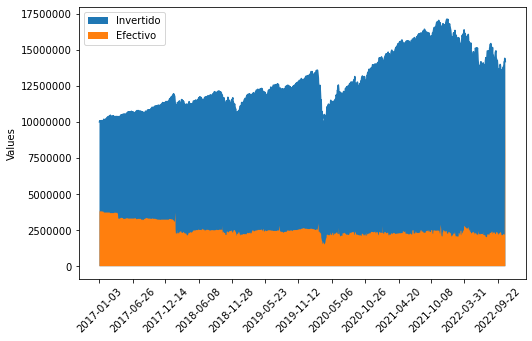

In [32]:
provisional = pd.DataFrame(robot.totales)

# Funcion para sumar el efectivo y el total de las distintas acciones
def row_sum(row):
    element1_value = row["DISH"][0]
    element2_sum = np.nansum([row[col][1] for col in provisional.columns if isinstance(row[col], list)])
    element1_and_2_sum = element1_value + element2_sum
    return pd.Series({"Efectivo": element1_value, "Invertido": element2_sum, "Total": element1_and_2_sum})

ppp = provisional.apply(row_sum, axis=1)

# Grafico de areas
plt.figure(figsize = (8, 5))
plt.fill_between(ppp.index, ppp['Total'], label='Invertido',alpha=1)
plt.fill_between(ppp.index, ppp['Efectivo'], label='Efectivo',alpha=1)
plt.plot(ppp["Total"])
plt.legend()

plt.xticks(ppp.index[::120], rotation = 45)

plt.ylabel('Values')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
plt.show()

In [34]:
total_capital = ppp['Total']
daily_return = total_capital.pct_change()
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1)
print("Annualized Return: {:.2f}%".format(annualized_return * 100))
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility * 100))
cumulative_returns = (1 + daily_return).cumprod()
cumulative_returns.iloc[0] = 1
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown*100))

daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

Annualized Return: 6.18%
Volatility: 16.90%
Maximum Drawdown: -33.67%
Sharpe Ratio: 0.38


## Limites 2,5%

/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/3594280689.py:5: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")
/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/289205683.py:95: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if fecha == pd.to_datetime(end_date).date() or fecha == pd.to_datetime("31-10-2022").date(): #or fecha == pd.to_datetime("29-12-2017").date():


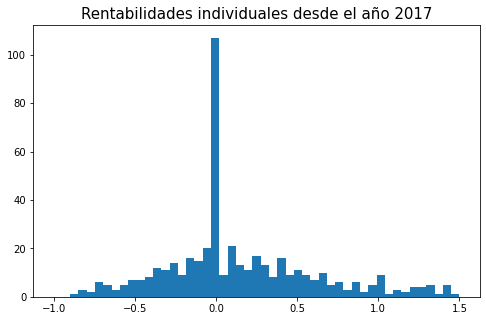

count    505.000000
mean       0.303908
std        0.822572
min       -2.725151
25%       -0.077617
50%        0.020987
75%        0.523915
max        7.293905
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 30.4947%



In [35]:
capital = 10000000
year = 2017

robot = Robot_CAPM(capital = capital, lim_inf = -0.025, lim_sup = 0.025)
robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")

plt.figure(figsize = (8, 5))

plt.hist(robot.rentabilidades.values(), bins = np.linspace(-1, 1.5, 50))
plt.title(f"Rentabilidades individuales desde el año {year}", fontsize = 15)
plt.show()
print(pd.Series(robot.rentabilidades.values()).describe())
r_total = round(robot.rentabilidad(robot.capital, robot.capital_inicial) * 100, 4)
print(f"La rentabilidad total del robot desde el año {year} fue de {r_total}%\n")

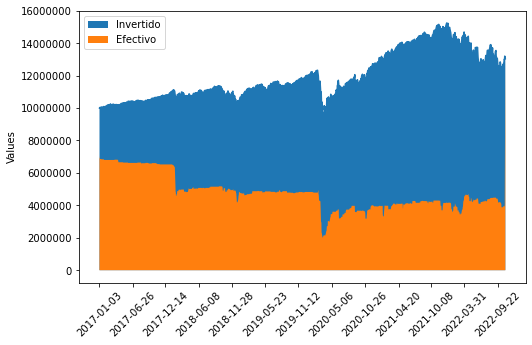

In [36]:
provisional = pd.DataFrame(robot.totales)

# Funcion para sumar el efectivo y el total de las distintas acciones
def row_sum(row):
    element1_value = row["DISH"][0]
    element2_sum = np.nansum([row[col][1] for col in provisional.columns if isinstance(row[col], list)])
    element1_and_2_sum = element1_value + element2_sum
    return pd.Series({"Efectivo": element1_value, "Invertido": element2_sum, "Total": element1_and_2_sum})

ppp = provisional.apply(row_sum, axis=1)

# Grafico de areas
plt.figure(figsize = (8, 5))
plt.fill_between(ppp.index, ppp['Total'], label='Invertido',alpha=1)
plt.fill_between(ppp.index, ppp['Efectivo'], label='Efectivo',alpha=1)
plt.plot(ppp["Total"])
plt.legend()

plt.xticks(ppp.index[::120], rotation = 45)

plt.ylabel('Values')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
plt.show()

In [37]:
total_capital = ppp['Total']
daily_return = total_capital.pct_change()
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1)
print("Annualized Return: {:.2f}%".format(annualized_return * 100))
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility * 100))
cumulative_returns = (1 + daily_return).cumprod()
cumulative_returns.iloc[0] = 1
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown*100))

daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

Annualized Return: 4.67%
Volatility: 14.28%
Maximum Drawdown: -28.76%
Sharpe Ratio: 0.32


## Limites 0,5%

/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/378703619.py:5: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")
/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/289205683.py:95: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if fecha == pd.to_datetime(end_date).date() or fecha == pd.to_datetime("31-10-2022").date(): #or fecha == pd.to_datetime("29-12-2017").date():


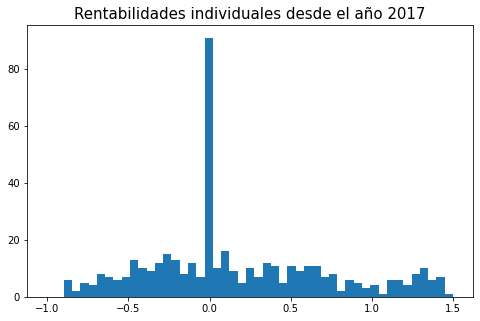

count    505.000000
mean       0.443221
std        1.198367
min       -3.078093
25%       -0.146084
50%        0.088280
75%        0.776486
max       16.537907
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 44.5653%



In [38]:
capital = 10000000
year = 2017

robot = Robot_CAPM(capital = capital, lim_inf = -0.005, lim_sup = 0.005)
robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")

plt.figure(figsize = (8, 5))

plt.hist(robot.rentabilidades.values(), bins = np.linspace(-1, 1.5, 50))
plt.title(f"Rentabilidades individuales desde el año {year}", fontsize = 15)
plt.show()
print(pd.Series(robot.rentabilidades.values()).describe())
r_total = round(robot.rentabilidad(robot.capital, robot.capital_inicial) * 100, 4)
print(f"La rentabilidad total del robot desde el año {year} fue de {r_total}%\n")

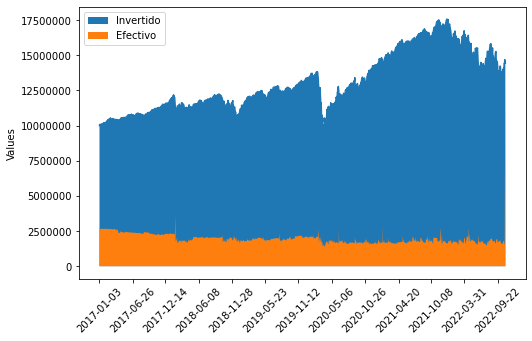

In [39]:
provisional = pd.DataFrame(robot.totales)

# Funcion para sumar el efectivo y el total de las distintas acciones
def row_sum(row):
    element1_value = row["DISH"][0]
    element2_sum = np.nansum([row[col][1] for col in provisional.columns if isinstance(row[col], list)])
    element1_and_2_sum = element1_value + element2_sum
    return pd.Series({"Efectivo": element1_value, "Invertido": element2_sum, "Total": element1_and_2_sum})

ppp = provisional.apply(row_sum, axis=1)

# Grafico de areas
plt.figure(figsize = (8, 5))
plt.fill_between(ppp.index, ppp['Total'], label='Invertido',alpha=1)
plt.fill_between(ppp.index, ppp['Efectivo'], label='Efectivo',alpha=1)
plt.plot(ppp["Total"])
plt.legend()

plt.xticks(ppp.index[::120], rotation = 45)

plt.ylabel('Values')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
plt.show()

In [40]:
total_capital = ppp['Total']
daily_return = total_capital.pct_change()
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1) * 100
print("Annualized Return: {:.2f}%".format(annualized_return))
average_daily_return = daily_return.mean() * 252
print("Average Daily Return: {:.2f}%".format(average_daily_return))
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility))
cumulative_returns = (1 + daily_return).cumprod()
cumulative_returns.iloc[0] = 1
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown*100))

daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

Annualized Return: 6.53%
Average Daily Return: 0.08%
Volatility: 0.18%
Maximum Drawdown: -34.75%
Sharpe Ratio: 0.39


## Limites 0,035%

/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/3662369488.py:5: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")
/var/folders/_6/t66f13vj5l77xtyzl8rfdht00000gn/T/ipykernel_983/289205683.py:95: UserWarning: Parsing '31-10-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if fecha == pd.to_datetime(end_date).date() or fecha == pd.to_datetime("31-10-2022").date(): #or fecha == pd.to_datetime("29-12-2017").date():


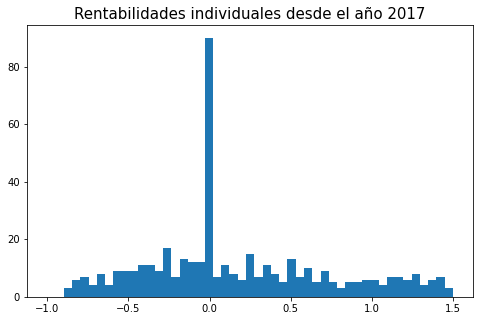

count    505.000000
mean       0.462610
std        1.340618
min       -3.068748
25%       -0.154713
50%        0.088280
75%        0.882600
max       20.937539
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 46.5236%



In [41]:
capital = 10000000
year = 2017

robot = Robot_CAPM(capital = capital, lim_inf = -0.00035, lim_sup = 0.00035)
robot.simular(lista_tickers, datos_precios, "01-01-" + str(year), "31-10-2022")

plt.figure(figsize = (8, 5))

plt.hist(robot.rentabilidades.values(), bins = np.linspace(-1, 1.5, 50))
plt.title(f"Rentabilidades individuales desde el año {year}", fontsize = 15)
plt.show()
print(pd.Series(robot.rentabilidades.values()).describe())
r_total = round(robot.rentabilidad(robot.capital, robot.capital_inicial) * 100, 4)
print(f"La rentabilidad total del robot desde el año {year} fue de {r_total}%\n")

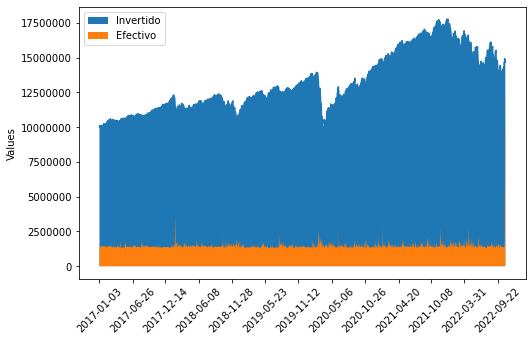

In [42]:
provisional = pd.DataFrame(robot.totales)

# Funcion para sumar el efectivo y el total de las distintas acciones
def row_sum(row):
    element1_value = row["DISH"][0]
    element2_sum = np.nansum([row[col][1] for col in provisional.columns if isinstance(row[col], list)])
    element1_and_2_sum = element1_value + element2_sum
    return pd.Series({"Efectivo": element1_value, "Invertido": element2_sum, "Total": element1_and_2_sum})

ppp = provisional.apply(row_sum, axis=1)

# Grafico de areas
plt.figure(figsize = (8, 5))
plt.fill_between(ppp.index, ppp['Total'], label='Invertido',alpha=1)
plt.fill_between(ppp.index, ppp['Efectivo'], label='Efectivo',alpha=1)
plt.plot(ppp["Total"])
plt.legend()

plt.xticks(ppp.index[::120], rotation = 45)
plt.ylabel('Values')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
plt.show()

In [43]:
total_capital = ppp['Total']
daily_return = total_capital.pct_change()
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1)
print("Annualized Return: {:.2f}%".format(annualized_return * 100))
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility * 100))
cumulative_returns = (1 + daily_return).cumprod()
cumulative_returns.iloc[0] = 1
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown*100))

daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

Annualized Return: 6.78%
Volatility: 17.97%
Maximum Drawdown: -35.34%
Sharpe Ratio: 0.40


In [10]:
with open("/Users/davidserrano/Documents/ICADE/5o ADE+ Analytics/TFG_Analytics/Datos/CAPM_Conclusiones.pkl", 'wb') as file:
    pickle.dump(total_capital, file)


# SP500 baseline

In [7]:
# Comparativa con el S&P 500
sp500 = yf.download('^GSPC', start='2017-01-01', end='2022-10-31')

prices = sp500['Close']

daily_return = prices.pct_change()

total_capital = (1 + daily_return).cumprod()
total_capital.iloc[0] = 1

# Rentabilidad Total
total_return = (total_capital.iloc[-1] / total_capital.iloc[0] - 1) * 100
print("Total Return: {:.2f}%".format(total_return))

# Rentabilidad Anualizada
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1) * 100
print("Annualized Return: {:.2f}%".format(annualized_return))

# Rentabilidad Promedio Diaria
average_daily_return = daily_return.mean() * 252
print("Average Daily Return: {:.2f}%".format(average_daily_return))

# Volatilidad
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility))

# MDD
drawdown = total_capital / total_capital.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))

# Sharpe Ratio
risk_free_rate = 0.03
risk_free_rate_daily = ((1 + risk_free_rate) ** (1 / 252) - 1) * 100
sharpe_ratio = (average_daily_return - risk_free_rate_daily) / volatility
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))


[*********************100%***********************]  1 of 1 completed
Total Return: 72.78%
Annualized Return: 9.85%
Average Daily Return: 0.11%
Volatility: 0.20%
Maximum Drawdown: -33.92%
Sharpe Ratio: 0.51
